# Create a process from random vectors and processes

The objective is to create a process defined from a random vector and a process.

We consider the following limit state function, defined as the difference between a degrading resistance $r(t) = R - bt$  and a time-varying load $S(t)$:
\begin{align*}
g(t)= r(t) - S(t) = R - bt - S(t)
\end{align*}
We propose the following probabilistic model: 
- $R$ is the initial resistance, and $R \sim \mathcal{N}(\mu_R, \sigma_R)$;   
- $b$ is the deterioration rate of the resistance; it is deterministic; 
- $S(t)$ is the time-varying stress, which is modeled by a stationary Gaussian process of mean value $\mu_S$, standard deviation $\sigma_S$ and a squared exponential covariance model;
- $t$ is the time, varying in $[0,T]$.

First, import the python modules: 

In [2]:
from  openturns import *
from openturns.viewer import View
from math import *

## 1. Create the gaussian process $(\omega, t) \rightarrow S(\omega,t)$

Create the mesh which is a regular grid on $[0,T]$, with $T=50$, by step =1:

In [6]:
b = 0.01
t0 = 0.0
step = 1
tfin = 50
n = round((tfin-t0)/step)
myMesh = RegularGrid(t0, step, n)

Create the squared exeponential covariance model: 
$$
C(s,t) = \sigma^2e^{-\frac{1}{2} \left( \dfrac{s-t}{l} \right)^2}
$$
where the scale parameter is $l=\frac{10}{\sqrt{2}}$ and the amplitude $\sigma = 1$.

In [7]:
l = 10/sqrt(2)
myCovKernel = SquaredExponential([l])
print('cov model = ', myCovKernel)

cov model =  SquaredExponential(scale=[7.07107], amplitude=[1])


Create the gaussian process $S(t)$:

In [8]:
S_proc = GaussianProcess(myCovKernel, myMesh)

Create the output random vector $Y = g(X)$:

In [5]:
Y = CompositeRandomVector(g,X)

## 2. Create the process $(\omega, t) \rightarrow R(\omega)-bt$

First, create the random variable $R \sim \mathcal{N}(\mu_R, \sigma_R)$, with $\mu_R = 5$ and $\sigma_R = 0.3$:

In [14]:
muR = 5
sigR = 0.3
R = Normal(muR, sigR)

The create the Dirac random variable $B = b$:

In [15]:
B = Dirac(b)

Then create the process $(\omega, t) \rightarrow R(\omega)-bt$ using the $FunctionalBasisProcess$ class and the functional basis :$\phi_1 : t \rightarrow 1$ and $\phi_2: -t \rightarrow t$ : 
$$
R(\omega)-bt = R(\omega)\phi_1(t) + B(\omega) \phi_2(t)
$$
with $(R,B)$ independent.

In [21]:
const_func = SymbolicFunction(['t'], ['1'])
linear_func = SymbolicFunction(['t'], ['-t'])
myBasis = Basis([const_func, linear_func])

coef = ComposedDistribution([R, B])

R_proc = FunctionalBasisProcess(coef, myBasis, myMesh)

## 3. Create the process $Z: (\omega, t) \rightarrow R(\omega)-bt + S(\omega, t)$

First, aggregate both processes into one process of dimension 2: $(R_{proc}, S_{proc})$

In [22]:
myRS_proc = AggregatedProcess([R_proc, S_proc])

Then create the spatial field function that acts only on the values of the process, keeping the mesh unchanged, using the *ValueFunction* class. 
We define the function $g$ on $\mathbb{R}^2$ by:
$$
g(x,y) = x-y
$$
in order to define the spatial field function $g_{dyn}$ that acts on fields, defined by: 
$$
\forall t\in [0,T], g_{dyn}(X(\omega, t), Y(\omega, t)) = X(\omega, t) - Y(\omega, t)
$$

In [24]:
g = SymbolicFunction(['x1', 'x2'], ['x1-x2'])
gDyn = ValueFunction(g, myMesh)

Now you have to create the final process $Z$ thanks to $g_{dyn}$:

In [25]:
Z_proc = CompositeProcess(gDyn, myRS_proc)

## 4. Draw some realizations of the process

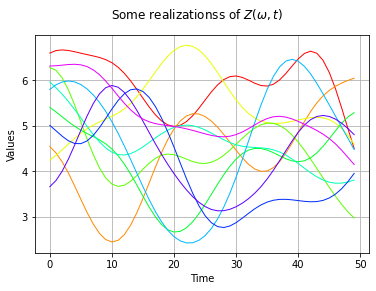

In [30]:
N=10
sampleZ_proc = Z_proc.getSample(N)
graph = sampleZ_proc.drawMarginal(0)
graph.setTitle(r'Some realizationss of $Z(\omega, t)$')

Show(graph)

## 5. Evaluate the probability that $Z(\omega, t) \in \mathcal{D}$

We define the domaine $\mathcal{D} = [2,4]$ and the event $Z(\omega, t) \in \mathcal{D}$:

In [34]:
domain = Interval([2], [4])
print('D = ', domain)
event = ProcessEvent(Z_proc, domain)

D =  [2, 4]


We use the Monte Carlo sampling to evaluate the probability:

In [36]:
MC_algo = ProbabilitySimulationAlgorithm(event)
MC_algo.setMaximumOuterSampling(1000000)
MC_algo.setBlockSize(100)
MC_algo.setMaximumCoefficientOfVariation(0.01)
MC_algo.run()

result = MC_algo.getResult()

proba = result.getProbabilityEstimate()
print('Probability = ', proba)
variance =  result.getVarianceEstimate()
print('Variance Estimate = ', variance)
IC90_low = proba- result.getConfidenceLength(0.90)/2
IC90_upp = proba + result.getConfidenceLength(0.90)/2
print('IC (90%) = [', IC90_low, ', ', IC90_upp, ']')

Probability =  0.7554545454545455
Variance Estimate =  5.6542634796078274e-05
IC (90%) = [ 0.7430860954526318 ,  0.7678229954564592 ]
